In [1]:
import numpy as np
import tensorflow as tf
from random import randint
import scipy as scipy
import scipy.interpolate as interpolate
import math
from random import *
from sklearn.decomposition import PCA
from sklearn.datasets import load_diabetes
from scipy.stats import logistic
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt2

import tflib as lib
import tflib.ops.linear
import tflib.ops.conv2d
import tflib.ops.batchnorm
import tflib.ops.deconv2d
import tflib.save_images
import tflib.plot


Lambda = 10.0
BATCH_SIZE = 45
BATCH_SIZE_2 = 100
dimensionality = 10
num_epochs = 100
num_iters = 1000
k=2
max_grad_norm = 1000
gamma = 1.0

# main parameters

C=10.0

# additional parameters
sigma=0.8

number_of_neurons_regr = 50
number_of_points = 442-37
number_of_neurons = number_of_points

/home/rust/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rust/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rust/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rust/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:5

In [2]:
diabetes = load_diabetes(return_X_y=False)
data = []
target = []
rr = np.random.permutation(442)
for x in rr:
    data.append(diabetes['data'][x])
    target.append(diabetes['target'][x])
# training data
_train_x = np.array(data)
_train_y = np.array(target)
print(_train_x.shape)
print(_train_y.shape)
print(np.max(_train_y))
rho = 0.5
var = np.var(_train_y)
print(rho)

(442, 10)
(442,)
346.0
0.5


In [3]:
new_lr = tf.placeholder(tf.float32, shape=[], name="new_learning_rate")
Dataplace = tf.placeholder(tf.float32, shape=(dimensionality, number_of_points))
Data = tf.placeholder(tf.float32, shape=(BATCH_SIZE, dimensionality))
outputs = tf.placeholder(tf.float32, shape=(BATCH_SIZE,1)) 

tf_data_x = gamma*tf.random_normal([BATCH_SIZE, dimensionality]) # аргументы функции
tf_data_y = tf.reduce_mean(tf.math.cos(tf.matmul(tf_data_x, Dataplace)), axis=1) # значения функции

tf_data_w = tf.placeholder(tf.float32, shape=(number_of_neurons,1))
tf_data_B = tf.placeholder(tf.float32, shape=(dimensionality,number_of_neurons))
tf_data_P = tf.placeholder(tf.float32, shape=(dimensionality, dimensionality))

tf_w_regr = tf.placeholder(tf.float32, shape=(number_of_neurons_regr,1))
tf_B_regr = tf.placeholder(tf.float32, shape=(dimensionality,number_of_neurons_regr))
tf_bias_regr = tf.placeholder(tf.float32, shape=(number_of_neurons_regr))


tf_data_second = gamma*tf.random_normal([BATCH_SIZE_2, dimensionality])
Lbd = tf.placeholder(tf.float32, shape=[], name="lambda")

# characteristic function parameters
w = tf.Variable(tf.random_normal([number_of_neurons,1], stddev=0.0), name="neuron_weights")
B = tf.Variable(initial_value=Dataplace, name="weights")
# regression function parameters
w_regr = tf.Variable(tf.random_normal([number_of_neurons_regr,1], stddev=0.35), name="neuron_weights")
B_regr = tf.Variable(tf.random_normal([dimensionality,number_of_neurons_regr], stddev=0.35), name="weights")
bias_regr = tf.Variable(tf.random_normal([number_of_neurons_regr], stddev=0.0), name="biases")

prediction = (2/number_of_neurons)*tf.matmul(tf.math.cos(tf.matmul(tf_data_x, B)), tf.nn.sigmoid(w))
penalty = tf.square((2/number_of_neurons)*tf.reduce_sum(tf.nn.sigmoid(w))-1.0)

out_loss = (1-rho)*tf.reduce_mean(tf.square(prediction - tf_data_y)) + C*penalty

prediction2 = (2/number_of_neurons)*tf.matmul(tf.math.cos(tf.matmul(tf_data_second, B)), tf.nn.sigmoid(w))
prediction_regr2 = tf.matmul(tf.nn.tanh(tf.nn.bias_add(tf.matmul(tf_data_second, B_regr), bias_regr)), w_regr)

grad_psi = tf.reshape(tf.gradients(prediction2, [tf_data_second])[0], [BATCH_SIZE_2, dimensionality])
grad_psi_regr = tf.reshape(tf.gradients(prediction_regr2, [tf_data_second])[0], [BATCH_SIZE_2, dimensionality])

tf_prediction2 = (2/number_of_neurons)*tf.matmul(tf.math.cos(tf.matmul(tf_data_second, tf_data_B)), tf.nn.sigmoid(tf_data_w))
tf_prediction_regr2 = tf.matmul(tf.nn.tanh(tf.nn.bias_add(tf.matmul(tf_data_second, tf_B_regr), tf_bias_regr)), tf_w_regr)

tf_data_grad_psi = tf.reshape(tf.gradients(tf_prediction2, [tf_data_second])[0], [BATCH_SIZE_2, dimensionality])
tf_data_grad_psi_regr = tf.reshape(tf.gradients(tf_prediction_regr2, [tf_data_second])[0], [BATCH_SIZE_2, dimensionality])

old_part = tf.matmul(tf_data_grad_psi, tf_data_P)
old_part_regr = tf.matmul(tf_data_grad_psi_regr, tf_data_P)

loss = out_loss + Lbd*(1-rho)*tf.reduce_mean(tf.reduce_sum(tf.square(tf.subtract(grad_psi, old_part)), axis=1)) + \
         Lbd*rho*tf.reduce_mean(tf.reduce_sum(tf.square(tf.subtract(grad_psi_regr, old_part_regr)), axis=1))/var

#offset = tf.random.uniform(shape=[], minval=0, maxval=12, dtype=tf.int32)*BATCH_SIZE
x_plus_error = Data+sigma*tf.random_normal([BATCH_SIZE, dimensionality])
regression = tf.matmul(tf.nn.tanh(tf.nn.bias_add(tf.matmul(x_plus_error, B_regr), bias_regr)), w_regr)
sdr = tf.reduce_mean(tf.square(regression-outputs))

loss_hybrid = loss + rho*sdr/var

In [4]:
target = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.5, beta2=0.9).minimize(loss_hybrid)

In [5]:
def sigmoid(x):
  return 1. /(1+np.exp(-x))

In [6]:
def euclidean_distance(pnt1, pnt2):
    '''Finds the distance between 2 points: pnt1, pnt2'''
    # element-wise computations are automatically handled by numpy
    return sum((pnt1 - pnt2) ** 2)

from collections import defaultdict

def find_majority(labels):
    '''Finds the majority class/label out of the given labels'''
    # defaultdict(type) is to automatically add new keys without throwing error.
    counter = defaultdict(int)
    for label in labels:
        counter[label] += 1

    # Finding the majority class.
    majority_count = max(counter.values())
    for key, value in counter.items():
        if value == majority_count:
            return key

def new_predict(k, train_pnts, train_labels, test_pnts):
    '''
    Predicts the new data-point's category/label by 
    looking at all other training labels
    '''
    # distances contains tuples of (distance, label)
    distances = [(euclidean_distance(test_pnts, pnt), label)
                    for (pnt, label) in zip(train_pnts, train_labels)]
    # sort the distances list by distances
    compare = lambda distance: distance[0]
    by_distances = sorted(distances, key=compare)
    # extract only k closest labels
    k_labels = [label for (_, label) in by_distances[:k]]
    # return the majority voted label
    return find_majority(k_labels)

def new_predict_regr(k, train_pnts, train_labels, test_pnts):
    '''
    Predicts the new data-point's category/label by 
    looking at all other training labels
    '''
    # distances contains tuples of (distance, label)
    distances = [(euclidean_distance(test_pnts, pnt), label)
                    for (pnt, label) in zip(train_pnts, train_labels)]
    # sort the distances list by distances
    compare = lambda distance: distance[0]
    by_distances = sorted(distances, key=compare)
    # extract only k closest labels
    k_labels = [label for (_, label) in by_distances[:k]]
    # return the majority voted label
    return np.mean(k_labels)

Current part is 0

Epoch 0
Iter 1100: loss: 2.7437

iter 1	train cost	2.74365234375
[134.6313       7.3156233    3.6041977    2.6069918    2.0494974
   1.3444679    1.3105644    0.94723684   0.6575228    0.3257028 ]
iter 2	total variance to retain	0.0015898346900939941
Epoch 1
Iter 2200: loss: 2.5736

iter 3	train cost	2.5736265182495117
[431.13464      9.700892     6.3684397    5.165432     3.9218736
   2.5190513    1.9489843    1.2114486    0.75916314   0.54422545]
iter 4	total variance to retain	0.00051116943359375
Epoch 2
Iter 3300: loss: 2.5001

iter 5	train cost	2.500061273574829
[957.8223     26.84641    13.200857    8.953437    7.388729    4.853086
   2.857505    2.318367    1.2841369   1.1097121]
iter 6	total variance to retain	0.00037997961044311523
Epoch 3
Iter 4400: loss: 2.4165

iter 7	train cost	2.4165337085723877
[1.6020767e+03 3.2738171e+01 1.7485039e+01 1.2366930e+01 9.9535522e+00
 6.4865603e+00 4.1190543e+00 2.8242567e+00 2.2270827e+00 1.2961607e+00]
iter 8	total vari

Iter 35200: loss: 0.4873

iter 63	train cost	0.4872729182243347
[3.1777144e+03 1.0198617e+00 2.1725720e-01 8.4261417e-02 4.8371553e-02
 3.5695933e-02 3.1523913e-02 2.4548562e-02 1.9478580e-02 6.4906506e-03]
iter 64	total variance to retain	0.0
Epoch 32
Iter 36300: loss: 0.4753

iter 65	train cost	0.47531500458717346
[3.8116248e+03 2.6489606e+00 1.6157946e-01 5.5044446e-02 4.5217399e-02
 3.9116424e-02 2.9144255e-02 2.6950072e-02 1.9811541e-02 9.1948723e-03]
iter 66	total variance to retain	0.0
Epoch 33
Iter 37400: loss: 0.4775

iter 67	train cost	0.477489709854126
[6.1393281e+03 9.4654961e+00 1.8805510e-01 6.9944508e-02 5.6080427e-02
 4.5192260e-02 3.9717577e-02 3.2540601e-02 2.4352778e-02 1.0495037e-02]
iter 68	total variance to retain	0.0
Epoch 34
Iter 38500: loss: 0.4679

iter 69	train cost	0.46792933344841003
[6.1958555e+03 8.7184458e+00 1.8264753e-01 9.5521003e-02 4.9388468e-02
 4.4516061e-02 3.4314770e-02 3.0749789e-02 2.4342868e-02 1.3611665e-02]
iter 70	total variance to retain	

Iter 69300: loss: 0.3667

iter 125	train cost	0.3667239844799042
[5.0636566e+04 1.1427576e+03 3.0258713e+01 9.3911409e+00 2.8452609e+00
 1.7402030e+00 2.6462105e-01 7.2228603e-02 4.6090733e-02 1.7229456e-02]
iter 126	total variance to retain	4.172325134277344e-07
Epoch 63
Iter 70400: loss: 0.3685

iter 127	train cost	0.3685009777545929
[4.7855746e+04 1.4379625e+03 3.3142414e+01 8.4402952e+00 3.6027048e+00
 2.5224168e+00 2.8996965e-01 9.1140330e-02 5.8258522e-02 2.4262516e-02]
iter 128	total variance to retain	5.364418029785156e-07
Epoch 64
Iter 71500: loss: 0.3691

iter 129	train cost	0.36910590529441833
[4.7265648e+04 1.4662294e+03 2.2559736e+01 9.5822716e+00 4.3687544e+00
 2.4666550e+00 2.7872610e-01 6.9891036e-02 4.7433592e-02 1.4783161e-02]
iter 130	total variance to retain	2.384185791015625e-07
Epoch 65
Iter 72600: loss: 0.3669

iter 131	train cost	0.36690154671669006
[4.5486258e+04 1.4596661e+03 2.0531984e+01 8.2293301e+00 4.5127802e+00
 2.0520105e+00 3.0460319e-01 1.1355446e-01 

Iter 102300: loss: 0.3413

iter 185	train cost	0.3413030207157135
[5.2561355e+04 1.3273147e+03 2.3953461e+01 1.4809236e+01 4.8643260e+00
 2.2417128e+00 5.5525041e-01 2.3300251e-01 1.4389697e-01 1.9947954e-02]
iter 186	total variance to retain	2.980232238769531e-07
Epoch 93
Iter 103400: loss: 0.3390

iter 187	train cost	0.33900290727615356
[5.6012434e+04 1.5967843e+03 1.9384203e+01 1.2724107e+01 4.7184296e+00
 2.4618561e+00 5.7037157e-01 2.5554052e-01 1.5457113e-01 1.2751694e-02]
iter 188	total variance to retain	1.7881393432617188e-07
Epoch 94
Iter 104500: loss: 0.3410

iter 189	train cost	0.34103497862815857
[5.4434441e+04 9.0835059e+02 1.9913277e+01 1.6071119e+01 6.2340426e+00
 2.2788453e+00 5.9455335e-01 3.2351458e-01 1.5252200e-01 1.9728750e-02]
iter 190	total variance to retain	2.384185791015625e-07
Epoch 95
Iter 105600: loss: 0.3346

iter 191	train cost	0.3345780670642853
[5.3545594e+04 1.0863149e+03 2.7302219e+01 1.4721621e+01 5.1771564e+00
 2.4889095e+00 5.4580188e-01 2.9982024

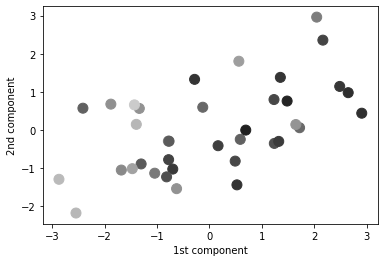

[[ 0.00872134 -0.05449141  0.04177202  0.03871249 -0.00875796 -0.02798139
   0.02569963 -0.00618478  0.00933585  0.02805118]
 [-0.05449141  0.36478764 -0.20245987 -0.21113455  0.06884134  0.1955166
  -0.24516606  0.08784385  0.03734946 -0.17605875]
 [ 0.04177202 -0.20245987  0.340939    0.25940424 -0.0079637  -0.0842346
  -0.08048892  0.08878326  0.2749775   0.13244504]
 [ 0.03871249 -0.21113455  0.25940424  0.2106965  -0.02102614 -0.09805587
   0.00715168  0.03473596  0.16237824  0.12351112]
 [-0.00875796  0.06884134 -0.0079637  -0.02102614  0.01699321  0.0401096
  -0.07492088  0.03477594  0.04617517 -0.02862966]
 [-0.02798139  0.1955166  -0.0842346  -0.09805587  0.0401096   0.10737061
  -0.15440503  0.06169099  0.05142785 -0.09067379]
 [ 0.02569963 -0.24516606 -0.08048892  0.00715168 -0.07492088 -0.15440503
   0.369946   -0.18934594 -0.30526543  0.08541981]
 [-0.00618478  0.08784385  0.08878326  0.03473596  0.03477594  0.06169099
  -0.18934594  0.1039129   0.18692769 -0.02149787]
 [ 

Iter 29700: loss: 0.5545

iter 253	train cost	0.5544803142547607
[1.04615808e+03 1.06093004e-01 8.37176368e-02 6.64824992e-02
 5.53140938e-02 4.29297015e-02 3.78019027e-02 2.53827646e-02
 2.05503479e-02 1.13842934e-02]
iter 254	total variance to retain	0.0
Epoch 27
Iter 30800: loss: 0.5311

iter 255	train cost	0.5311067700386047
[2.0286421e+03 1.4871229e-01 7.5235777e-02 6.5923676e-02 5.8508102e-02
 4.0462576e-02 3.9974552e-02 2.7059736e-02 1.5709328e-02 1.2319908e-02]
iter 256	total variance to retain	0.0
Epoch 28
Iter 31900: loss: 0.5158

iter 257	train cost	0.5158287286758423
[1.6905160e+03 1.1858839e-01 1.1026296e-01 8.4972501e-02 6.5406807e-02
 5.6695223e-02 4.2014748e-02 3.5081297e-02 1.9127211e-02 1.1959597e-02]
iter 258	total variance to retain	0.0
Epoch 29
Iter 33000: loss: 0.5058

iter 259	train cost	0.5057670474052429
[2.2434695e+03 2.4707824e-01 1.2604959e-01 7.3530458e-02 6.6446438e-02
 4.8809223e-02 3.7838023e-02 3.3225887e-02 2.0614039e-02 1.2884352e-02]
iter 260	total v

Iter 64900: loss: 0.3664

iter 317	train cost	0.3664402663707733
[4.1533109e+04 8.5718719e+02 7.9615645e+00 4.5015354e+00 3.1174932e+00
 3.0289227e-01 6.4233877e-02 3.8532488e-02 2.6320057e-02 1.6946759e-02]
iter 318	total variance to retain	5.960464477539063e-08
Epoch 59
Iter 66000: loss: 0.3700

iter 319	train cost	0.3699699342250824
[4.1002523e+04 7.5784369e+02 8.4452295e+00 7.6871099e+00 3.2227159e+00
 3.4553713e-01 6.9600463e-02 3.7907444e-02 3.1043749e-02 2.3662720e-02]
iter 320	total variance to retain	5.960464477539063e-08
Epoch 60
Iter 67100: loss: 0.3697

iter 321	train cost	0.3696810007095337
[4.64760703e+04 7.23611938e+02 1.03748198e+01 7.39457321e+00
 3.48308945e+00 3.69705707e-01 6.73668832e-02 3.41761075e-02
 2.85248123e-02 1.43677415e-02]
iter 322	total variance to retain	1.1920928955078125e-07
Epoch 61
Iter 68200: loss: 0.3656

iter 323	train cost	0.3656355142593384
[4.5869918e+04 8.7538214e+02 1.0069300e+01 6.8868418e+00 3.0255194e+00
 4.4867307e-01 1.0029540e-01 4.82

In [ ]:
scores = []
scores3 = []
for part in range(10):
    print("Current part is %d\n" % part)
    train_x = np.concatenate((_train_x[0:(part*37)], _train_x[(part+1)*37:442]), axis=0)
    train_y = np.concatenate((_train_y[0:(part*37)], _train_y[(part+1)*37:442]), axis=0)
    test_x = _train_x[part*37:(part+1)*37]
    test_y = _train_y[part*37:(part+1)*37]
    scaler = preprocessing.StandardScaler().fit(train_x)
    train_x = scaler.transform(train_x)
    test_x = scaler.transform(test_x)
    transpose_train_x = np.transpose(train_x)

    cur_w = np.random.normal(0, 0.35, (number_of_neurons,1))
    cur_B =  np.random.normal(0, 0.35, (dimensionality, number_of_neurons))
    cur_biases = np.zeros((number_of_neurons))
    cur_P = np.zeros((dimensionality, dimensionality)) 
    cur_w_regr = np.random.normal(0, 0.35, (number_of_neurons_regr,1))
    cur_B_regr = np.random.normal(0, 0.35, (dimensionality, number_of_neurons_regr))
    cur_bias_regr = np.random.normal(0, 0.35, (number_of_neurons_regr))

    O = np.zeros((dimensionality, k)) 
    cur_iter = 0
    
    sess = tf.Session()
    init = tf.global_variables_initializer()
    sess.run(init, feed_dict={Dataplace: transpose_train_x})
    
    for epoch in range(num_epochs):
        print("Epoch %d" %(epoch))
        for iteration in range(num_iters):
            offset = (cur_iter % 9)*BATCH_SIZE
            sample_x = np.reshape(train_x[offset:(offset+BATCH_SIZE)], (BATCH_SIZE, dimensionality))
            sample_y = np.reshape(train_y[offset:(offset+BATCH_SIZE)], (BATCH_SIZE, 1))
            sess.run(target, feed_dict={Data: sample_x, outputs:sample_y, Lbd: Lambda, Dataplace: transpose_train_x,
                                        tf_data_w: cur_w,
                                        tf_data_B: cur_B,
                                        tf_data_P: cur_P,
                                        tf_w_regr: cur_w_regr,
                                        tf_B_regr: cur_B_regr,
                                        tf_bias_regr: cur_bias_regr})
            cur_iter = cur_iter+1
        reses = []
        for i in range(100):
            offset = (cur_iter % 9)*BATCH_SIZE
            sample_x = np.reshape(train_x[offset:(offset+BATCH_SIZE)], (BATCH_SIZE, dimensionality))
            sample_y = np.reshape(train_y[offset:(offset+BATCH_SIZE)], (BATCH_SIZE, 1))
            res = sess.run([loss_hybrid], feed_dict={Data: sample_x, outputs:sample_y, Lbd: Lambda, Dataplace: transpose_train_x, 
                                        tf_data_w: cur_w,
                                        tf_data_B: cur_B,
                                        tf_data_P: cur_P,
                                        tf_w_regr: cur_w_regr,
                                        tf_B_regr: cur_B_regr,
                                        tf_bias_regr: cur_bias_regr})
            reses.append(res)
            cur_iter = cur_iter+1
        print ("Iter %d: loss: %.4f\n" %(cur_iter, np.mean(np.array(reses))))
        lib.plot.plot('train cost', np.mean(np.array(reses)))
        lib.plot.tick()
        lib.plot.flush()

        cur_w, cur_B, cur_w_regr, cur_B_regr, cur_bias_regr = sess.run([w, B, w_regr, B_regr, bias_regr])

        third_grad_psi = np.reshape(sess.run([grad_psi]), (BATCH_SIZE_2, dimensionality))
        third_grad_psi_regr = np.reshape(sess.run([grad_psi_regr]), (BATCH_SIZE_2, dimensionality))
        for r in range(1000):
            sess.run([tf_data_second])
            np.concatenate((third_grad_psi, np.reshape(sess.run([grad_psi]), (BATCH_SIZE_2, dimensionality))), axis=0) 
            np.concatenate((third_grad_psi_regr, np.reshape(sess.run([grad_psi_regr]), (BATCH_SIZE_2, dimensionality))), axis=0)

        M = (1-rho)*np.matmul(np.transpose(third_grad_psi), third_grad_psi)+\
            rho*np.matmul(np.transpose(third_grad_psi_regr), third_grad_psi_regr)
        u, s, vh = np.linalg.svd(M, full_matrices=True)
        O = u[:,0:k:1]
        print(s)
        cur_P = np.matmul(O, np.transpose(O))
        tvr = 1-np.sum(np.multiply(s[0:k],s[0:k]))/np.sum(np.multiply(s,s))
        lib.plot.plot('total variance to retain', tvr)
        lib.plot.tick()
        lib.plot.flush()
    reduced_train_x = np.matmul(train_x, O)
    reduced_test_x = np.matmul(test_x, O)
    reg = LinearRegression().fit(reduced_train_x, train_y)
    score = reg.score(reduced_test_x, test_y)
    scores.append(score)
    print ("Part %d: score on test %.4f\n" %(part, score))
    color = [str(item/346.) for item in test_y]
    plt2.close()
    plt2.scatter(np.transpose(reduced_test_x)[0], np.transpose(reduced_test_x)[1], s=100, c=color)
    plt2.xlabel("1st component")
    plt2.ylabel("2nd component")
    plt2.show()
    sess.close()
    print(cur_P)
    
    test_y_prediction = []
    for test_image in reduced_test_x:
        pred = new_predict_regr(10, reduced_train_x, train_y, test_image)
        test_y_prediction.append(pred)
    score3 = 100*(1.0-np.mean((np.array(test_y_prediction)- test_y)**2)/np.var(test_y))
    scores3.append(score3)
    print('acc:', str(round(score3, 2))+'%')
print ("Average 10-NN acc on test %.4f\n" %(np.mean(np.array(scores3))))
print ("Average score on test %.4f\n" %(np.mean(np.array(scores))))